[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/9_nb_feature_engineering.ipynb) 

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/code
!pip install --upgrade pip
!pip install -r requirements.txt

/content/drive/MyDrive/code
     |████████████████████████████████| 2.1 MB 5.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 56.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 837.0/837.0 KB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.9/793.9 KB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.1/38.1 MB 20.9 MB/s eta 0:00:00
     ━━━━━

In [3]:
# Import standard Python libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from pickle import dump, load
from os import path
#from sklearn.metrics import roc_auc_score
import holidays
from datetime import datetime
from math import sin, cos, pi, ceil
from pyentrp import entropy as ent
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
%matplotlib inline
plt.rcParams.update({'figure.figsize':(10,2), 'figure.dpi':100})

import time
import json

# Some configuration of the plots we will create later
%matplotlib inline  
plt.rcParams["figure.figsize"] = (12,6)

#### Helper Functions


In [4]:
# replace outliers in fridge:
def replace_outlier_IQR(df_col, col):
    Q1=df_col[col].quantile(0.05)
    Q3=df_col[col].quantile(0.95)
    IQR=Q3-Q1
    print(df_col.loc[((df_col[col] < (Q1-1.5*IQR))| (df_col[col] > (Q3+1.5*IQR))), col])
    df_col.loc[((df_col[col] < (Q1-1.5*IQR))| (df_col[col] > (Q3+1.5*IQR))), col] = None
    return df_col

def add_week_of_month(df):
    df['week_in_month_dt'] = pd.to_numeric(df.index.day/7)
    df['week_in_month_dt'] = df['week_in_month_dt'].apply(lambda x: ceil(x))
    return df

days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

def sin_cos(n):
    theta = 2 * pi * n
    return (sin(theta), cos(theta))

def get_cycles(d):
    '''
    Get the cyclic properties of a datetime,
    represented as points on the unit circle.
    Arguments
    ---------
    d : datetime object
    Returns
    -------
    dictionary of sine and cosine tuples
    '''
    month = d.month - 1
    day = d.day - 1

    return {
        'month': sin_cos(month / 12),
        'mweek': sin_cos(d.day / 7),
        'weekday': sin_cos(d.weekday() / 7),
        'hour': sin_cos(d.hour / 24)#,
        #'minute': sin_cos(d.minute / 60),
        #'second': sin_cos(d.second / 60)
    }
    
def intervaled_cumsum(a, trigger_val=1, start_val = 0, invalid_specifier=-1):
    out = np.ones(a.size,dtype=int)    
    idx = np.flatnonzero(a==trigger_val)
    if len(idx)==0:
        return np.full(a.size,invalid_specifier)
    else:
        out[idx[0]] = -idx[0] + 1
        out[0] = start_val
        out[idx[1:]] = idx[:-1] - idx[1:] + 1
        np.cumsum(out, out=out)
        out[:idx[0]] = invalid_specifier
        return out

def intervaled_cumsum_greater(a, trigger_val=0, start_val = 0, invalid_specifier=-1):
    out = np.ones(a.size,dtype=int)    
    idx = np.flatnonzero(a>trigger_val)
    if len(idx)==0:
        return np.full(a.size,invalid_specifier)
    else:
        out[idx[0]] = -idx[0] + 1
        out[0] = start_val
        out[idx[1:]] = idx[:-1] - idx[1:] + 1
        np.cumsum(out, out=out)
        out[:idx[0]] = invalid_specifier
        return out

def get_tlags_window(df, col_names, tlag):

   dataframe_w = pd.DataFrame()
   for col in col_names:
     _df = df[[col, 'datetime']]
     _df['time'] = _df['datetime'].dt.hour
     _df['date'] = _df['datetime'].dt.date
     _df = _df.pivot(index='date', columns='time', values=col)
     
     for i in range(tlag):
        dataframe_w[col + '_t-'+str(i)] = _df[i]
   
   dataframe_w = dataframe_w[1:-1]
   dataframe_w.dropna(inplace=True)
   dataframe_w.index = pd.to_datetime(dataframe_w.index)
   
   nparray = np.empty((dataframe_w.shape[0], tlag, len(col_names)))
   for i in range(len(col_names)):
      nparray[:,:,i] = dataframe_w.values[:,i*tlag:(i+1)*tlag]
   return dataframe_w, nparray

# Fil empty dataframe with the time lag observations per variable as features for 24h
def get_tlags_rolling_features(df, col_names, tlag):

   dataframe = pd.DataFrame()
   for col in col_names:
     for i in range((tlag-1),0,-1):
       dataframe[col + '_t-'+str(i)] = df[col].shift(i).values[:]
     dataframe[col] = df[col]
   
   dataframe = dataframe[(tlag-1):]
   dataframe.dropna(inplace=True)
   dataframe.reset_index(drop=True, inplace=True)
   
   nparray = np.empty((dataframe.shape[0], tlag, len(col_names)))
   for i in range(len(col_names)):
      nparray[:,:,i] = dataframe.values[:,i*tlag:(i+1)*tlag]
   return dataframe, nparray

# Data Preparation:
1. Check for nan and duplicates (already cleaned out)
2. replace outliers for Fridge (target variable) and for Wind speed (feature)
3. Get cyclical features of month, day, weekday, hour
4. Using StandardScaler to normalise data (first training and then applied to complete df)
5. Structure data into windows or rolling windows, with last 24h as features.
6. Get extra features: av/max/min of features and holiday and day of the week indicator.
7. Save dataframe with past hourly values as features (extra column) and save numpy array with 3 dimensions where time lags are seperate dimension.

### Load and preprocess data:


In [5]:
dataset = 'refit' # 'refit' 'ampds' , 'pecansd', 'greend'
train_test = 'train' # 'train', 'test'
split_ratio = 0.2
tlag = 24
path_to_data_folder = '/content/drive/MyDrive/'

In [6]:
# Data Cleaning Pipeline: Names: ['Time', 'Fridge', 'Dryer', 'Washing Machine', 'Dishwasher',
#       'Television', 'Temperature', 'relative Humidity',
#       'Wind Speed']
# REFIT Data: training: refit_h1_full.csv test: refit_test.csv
if dataset=='refit':
  data_url = f'{path_to_data_folder}data/REFIT/'

  if train_test=='train':
    df = pd.read_csv(f'{data_url}refit_h1_full.csv')
  elif train_test=='test':
    df = pd.read_csv(f'{data_url}refit_test.csv')
  else:
    raise AssertionError('Please specify train or test in variable train_test')
  
  c_holidays = holidays.England(years=[2013,2014,2015])
  appl_names = ['Fridge', 'Dryer', 'Washing Machine', 'Dishwasher', 'Television']
  df.rename(columns = {'index' : 'Time'}, inplace=True)

  

# AMPds: train: ampds_full.csv  test: ampds_test.csv
elif dataset=='ampds':
  data_url = f'{path_to_data_folder}data/AMPds/'
  if train_test=='train':
    df = pd.read_csv(f'{data_url}ampds_full.csv')
  elif train_test=='test':
    df = pd.read_csv(f'{data_url}ampds_test.csv')
  else:
    raise AssertionError('Please specify train or test in variable train_test')

  c_holidays = holidays.Canada(years=[2012, 2013, 2014])
  df.rename(columns = {'time' : 'Time', 'clothes_washer': 'Washing Machine', 'dish_washer': 'Dishwasher', 'clothes_dryer': 'Dryer', 'fridge': 'Fridge', 'tv_pvr': 'Television'}, inplace=True)
  df = df[['Time', 'Fridge', 'Dryer', 'Washing Machine', 'Dishwasher', 'Television', 'Temperature', 'Relative Humidity', 'Wind Speed']]
  appl_names = ['Fridge', 'Dryer', 'Washing Machine', 'Dishwasher','Television']

#GreenD: train: buildin0_df_train.csv test: buildin0_df_test.csv
elif dataset=='greend':
  data_url = f'{path_to_data_folder}data/GreenD/'
  if train_test=='train':
    df = pd.read_csv(f'{data_url}buildin0_df_train.csv')
  elif train_test=='test':
    df = pd.read_csv(f'{data_url}buildin0_df_test.csv')
  else:
    raise AssertionError('Please specify train or test in variable train_test')

  c_holidays = holidays.Austria(years=[2013, 2014])
  c_holidays[datetime(2014, 10, 10)] = 'Carinthian Plebiscite'
  df['Time'] = pd.to_datetime(df['Time'])
  df = df[['Time', 'Fridge', 'Washing Machine', 'Dishwasher', 'Television', 'Temperature', 'Relative Humidity', 'Wind Speed']]
  appl_names = ['Fridge', 'Washing Machine', 'Dishwasher', 'Television']
  df.set_index('Time', inplace=True)

#Pecan: train: 3996_train.csv test: 3996_test.csv / New York
elif dataset=='pecansd':
  data_url = f'{path_to_data_folder}data/PecanSD/'
  if train_test=='train':
    df = pd.read_csv(f'{data_url}3996_train.csv')
    print(df.shape)
  elif train_test=='test':
    df = pd.read_csv(f'{data_url}3996_test.csv')
  else:
    raise AssertionError('Please specify train or test in variable train_test')
    
  c_holidays = holidays.UnitedStates(years=[2019]) 
  df['Time'] = pd.to_datetime(df['Time'])
  df = df[['Time', 'Fridge', 'Dryer', 'Washing Machine', 'Dishwasher', 'Temperature', 'Relative Humidity', 'Wind Speed']]
  appl_names = ['Fridge', 'Dryer', 'Washing Machine', 'Dishwasher']
  df.set_index('Time', inplace=True)

else:
  print('Please provide a valid dataset name from refit, ampds, pecansd or greend')

# check data
print('checking clean dataset:')
print(f'Using dataset url: {data_url}')
print('Number of missings')
print(df.isnull().sum())
print('Number of duplicates')
print(df[df.duplicated()])
print('Columns types')
print(df.dtypes)
print('Shape of Dataframe')
print(df.shape)

# Comment out for REFIT data:
df.dropna(inplace=True)
print('Shape after dropping missings')
print(df.shape)

# Store column names for later use
fe_names = ['Temperature', 'Relative Humidity', 'Wind Speed']
col_names = appl_names + fe_names

checking clean dataset:
Using dataset url: /content/drive/MyDrive/data/REFIT/
Number of missings
Time                 0
Fridge               0
Dryer                0
Washing Machine      0
Dishwasher           0
Television           0
Temperature          0
Relative Humidity    0
Wind Speed           0
dtype: int64
Number of duplicates
Empty DataFrame
Columns: [Time, Fridge, Dryer, Washing Machine, Dishwasher, Television, Temperature, Relative Humidity, Wind Speed]
Index: []
Columns types
Time                  object
Fridge               float64
Dryer                float64
Washing Machine      float64
Dishwasher           float64
Television           float64
Temperature          float64
Relative Humidity    float64
Wind Speed           float64
dtype: object
Shape of Dataframe
(9277, 9)
Shape after dropping missings
(9277, 9)


In [7]:
df

,Time,Fridge,Dryer,Washing Machine,Dishwasher,Television,Temperature,Relative Humidity,Wind Speed
0,2013-11-04 09:00:00,36.922680,0.0,0.000000,0.0,0.810997,5.777333,78.066667,1.90200
1,2013-11-04 10:00:00,0.000000,0.0,0.000000,0.0,0.000000,7.186000,73.962500,2.13525
2,2013-11-04 11:00:00,30.456814,0.0,0.000000,0.0,0.000000,8.450000,72.830000,2.33425
3,2013-11-04 12:00:00,9.220826,0.0,0.000000,0.0,0.000000,9.522500,65.207500,3.07175
4,2013-11-04 13:00:00,9.972628,0.0,311.905109,0.0,0.000000,9.852500,65.977500,3.54825
...,...,...,...,...,...,...,...,...,...
9272,2015-01-12 20:00:00,0.214286,0.0,0.005792,0.0,10.486486,5.776500,88.625000,0.69000
9273,2015-01-12 21:00:00,23.350379,0.0,0.001894,0.0,32.395833,5.817750,91.025000,0.48400
9274,2015-01-12 22:00:00,15.115312,0.0,0.001890,0.0,30.145558,5.667750,95.100000,0.95425
9275,2015-01-12 23:00:00,0.000000,0.0,0.000000,0.0,0.000000,6.026500,95.900000,0.44950


#### Data Cleaning: Imputating missing Datetimes

In [8]:
# next lines only for refit, ampds
if dataset in ('refit', 'ampds'):
  df['Time'] = pd.to_datetime(df['Time'])
  idx = pd.date_range(start = min(df['Time']), end = max(df['Time']),freq='H')
  df['Time'] = pd.to_datetime(df['Time'])
  df.set_index('Time', inplace=True)
  df = df.reindex(idx)
  df['date'] = df.index.date


df_test = df.copy()

# next line only for traindata refit:
if (dataset=='refit' and train_test=='train'):
  df_test = df.loc[(df['date'] < pd.to_datetime("2014-01-24")) | (df['date'] > pd.to_datetime("2014-03-06"))].copy() 
elif (dataset=='refit' and train_test=='test'):
  df_test = df.loc[df['date'] < pd.to_datetime("2015-05-10")].copy()
  print('Test')
else: 
  pass


df_test['time'] = df_test.index.time
df_test['weekday'] = df_test.index.weekday
df_test['week'] = df_test.index.week
print(f'dataset shape: {df_test.shape}')

dataset shape: (9424, 12)


/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


In [9]:
# for appliance imputation
lookup_df = df_test.groupby(['weekday', 'time']).mean()
indexcolum_day = 'weekday'
for col in appl_names: #,
  df_nan = df_test[df_test[col].isnull()].copy()
  for i in range(len(df_nan)):
    day_sel = df_nan[df_nan[col].isnull()][indexcolum_day][i]
    time_sel = df_nan[df_nan[col].isnull()]['time'][i]
    replace_value = lookup_df.loc[day_sel, time_sel][col]
    time_stamp = df_nan[df_nan[col].isnull()].index[i]
    df_test.loc[time_stamp, col] = replace_value 
    
# for weather feature imputation
lookup_df = df_test.groupby(['week', 'time']).mean()
indexcolum_day = 'week'
for col in fe_names: #, 
  df_nan = df_test[df_test[col].isnull()].copy()
  for i in range(len(df_nan)):
    day_sel = df_nan[df_nan[col].isnull()][indexcolum_day][i]
    time_sel = df_nan[df_nan[col].isnull()]['time'][i]
    replace_value = lookup_df.loc[day_sel, time_sel][col]
    time_stamp = df_nan[df_nan[col].isnull()].index[i]
    df_test.loc[time_stamp, col] = replace_value

In [10]:
df_test.reset_index(inplace=True)
df_test.rename(columns={'index':'Time'}, inplace=True)
df = df_test[["Time"]+ col_names].copy()

time_index = pd.to_datetime(df['Time'])
print(df.isna().sum())
print(df.shape)

Time                 0
Fridge               0
Dryer                0
Washing Machine      0
Dishwasher           0
Television           0
Temperature          0
Relative Humidity    0
Wind Speed           0
dtype: int64
(9424, 9)


#### Replace Outliers

In [11]:
# Check for outlieres: plt.plot(df['Fridge'])
# only relevant for Pecan and Refit
df = replace_outlier_IQR(df, 'Fridge')
df['Fridge'] = df['Fridge'].interpolate()

# Only relevant for refit
df = replace_outlier_IQR(df, 'Wind Speed')
df['Wind Speed'] = df['Wind Speed'].interpolate()
print(df.isna().sum())

df.to_csv(f'{data_url}original_{train_test}data_imputed_outlreplaced.csv', index=False)

# pecan test: 
#df.drop(list(np.arange(248,271))).to_csv(f'{data_url}original_testdata_imputed_outlreplaced.csv', index=False)

925    897.786667
935    511.423333
958    516.109797
Name: Fridge, dtype: float64
746       7.43850
747       7.77275
748       7.55625
5689     18.19075
5692    210.51400
6060     24.86600
6061    880.77500
6062    775.50000
6181    176.85375
6182    155.77000
6205    176.85375
6206    155.77000
7797     38.69550
7798     41.76350
Name: Wind Speed, dtype: float64
Time                 0
Fridge               0
Dryer                0
Washing Machine      0
Dishwasher           0
Television           0
Temperature          0
Relative Humidity    0
Wind Speed           0
dtype: int64


In [12]:
testing = pd.read_csv(f'{data_url}original_{train_test}data_imputed_outlreplaced.csv')
testing.shape

(9424, 9)

#### Data Pereprocessing
(save data afterwards and save steps to another notebook)

In [13]:
scaled_col_list = []


if train_test=='train':
  print('Fitting and saving scalers')
  for i in appl_names:
    preproc_target = StandardScaler()
    preproc_target.fit(df[[i]][:-int(np.floor(len(df)*split_ratio))])
    col_prpr = pd.DataFrame(preproc_target.transform(df[[i]]), columns=[i])
    scaled_col_list.append(col_prpr)    
    # save the scaler
    dump(preproc_target, open(f'{data_url}std_scaler_{i}.pkl', 'wb'))

  preproc_features = StandardScaler()
  preproc_features.fit(df[fe_names][:-int(np.floor(len(df)*split_ratio))])
  fe_prpr = pd.DataFrame(preproc_features.transform(df[fe_names]), columns=fe_names)
  dump(preproc_features, open(f'{data_url}std_scaler_weatherfe.pkl', 'wb'))
  scaled_col_list.append(fe_prpr)

else:
  print('Loading prefitted scalers')
  for i in appl_names:
    preproc_target = load(open(f'{data_url}std_scaler_{i}.pkl', 'rb'))
    col_prpr = pd.DataFrame(preproc_target.transform(df[[i]]), columns=[i])
    scaled_col_list.append(col_prpr)

  preproc_features = load(open(f'{data_url}std_scaler_weatherfe.pkl', 'rb'))
  fe_prpr = pd.DataFrame(preproc_features.transform(df[fe_names]), columns=fe_names)
  scaled_col_list.append(fe_prpr)

df = pd.concat(scaled_col_list, axis=1)

print(f'Number of Nan: {df.isna().sum().sum()}')
print(f'df.shape: {df.shape}')

df['datetime'] = time_index

#df.to_csv(f'/content/drive/MyDrive/Master_Thesis/data/REFIT_prep/{train_test}data_datetimefe/train_preprocessed.csv', index=False)

Fitting and saving scalers
Number of Nan: 0
df.shape: (9424, 8)


### Past Summary Features over time series 

In [14]:
# Autocorrelation plot t find important time lags
#REFIT:
#from pandas import read_csv
#from statsmodels.graphics.tsaplots import plot_acf
#from statsmodels.tsa.seasonal import seasonal_decompose
#from matplotlib import pyplot
#
#for col in appl_names:
#  print(col)
#  plot_acf(df[[col]], lags=240)
#  pyplot.show()
  #multiplicative_decomposition = seasonal_decompose(df[col], freq=12)
  #multiplicative_decomposition.plot()
  #plt.show()

# mav 12h; tag davor, 3tage vorher


In [15]:
# moving avergaes and max over last 48h 72h 12h 24h

for col in appl_names: 
  df[col+'_mav48h_past'] = df[col].rolling(window=48).mean()
  df[col+'_mav72h_past'] = df[col].rolling(window=72).mean()
  df[col+'_mav12h_past'] = df[col].rolling(window=12).mean()
  df[col+'_mav24h_past'] = df[col].rolling(window=24).mean()
  df[col+'_mmax48h_past'] = df[col].rolling(window=48).max()
  df[col+'_mmax72h_past'] = df[col].rolling(window=72).max()
  df[col+'_mmax12h_past'] = df[col].rolling(window=12).max()
  df[col+'_mmax24h_past'] = df[col].rolling(window=24).max()

col_names = list(df.columns)
col_names.remove('datetime')

### Mutual Summary Features past

In [16]:
#sum/diff/mult/quotient 5+4+3+2+1
from  itertools import combinations
combos = list(combinations(appl_names,2))

for pair in combos: 
  df[f'{pair[0]}_{pair[1]}_sum_past'] = df[pair[0]]+df[pair[1]]
  df[f'{pair[0]}_{pair[1]}_mean_past'] = df[[pair[0], pair[1]]].mean(axis=1)
  df[f'{pair[0]}_{pair[1]}_mul_past'] = df[pair[0]]*df[pair[1]]
  df[f'{pair[0]}_{pair[1]}_std_past'] = df[[pair[0], pair[1]]].std(axis=1)

df['total_mean'] = df[appl_names].mean(axis=1)
df['total_std'] = df[appl_names].std(axis=1)

col_names = list(df.columns)
col_names.remove('datetime')

### Get additional Time Features

In [17]:
df['holiday_dt'] = [ 1 if x in c_holidays else 0 for x in df['datetime']]
df['month_dt'] = df.datetime.dt.month
df['weekday_dt'] = df.datetime.dt.weekday
df['hour_dt'] = df.datetime.dt.hour

df.set_index('datetime', inplace=True)
df = add_week_of_month(df)
df.reset_index(inplace=True)
df['holiday_dt'] = np.where(df['weekday_dt'].isin([5,6]), 1, df['holiday_dt'])

#### Sinus/Cosine tranformation

In [18]:
month_tr_s = []
month_tr_c = []
mweek_tr_s = []
mweek_tr_c = []
weekday_tr_s = []
weekday_tr_c = []
hour_tr_s = []
hour_tr_c = []

for index, row in time_index.iteritems():
  dict_values = get_cycles(row)
  month_tr_s.append(dict_values['month'][0])
  month_tr_c.append(dict_values['month'][1])
  mweek_tr_s.append(dict_values['mweek'][0])
  mweek_tr_c.append(dict_values['mweek'][1])
  weekday_tr_s.append(dict_values['weekday'][0])
  weekday_tr_c.append(dict_values['weekday'][1])
  hour_tr_s.append(dict_values['hour'][0])
  hour_tr_c.append(dict_values['hour'][1])


df['month_tr_s_dt'], df['mweek_tr_s_dt'], df['weekday_tr_s_dt'], df['hour_tr_s_dt'] = pd.Series(month_tr_s), pd.Series(mweek_tr_s), pd.Series(weekday_tr_s), pd.Series(hour_tr_s)
df['month_tr_c_dt'], df['mweek_tr_c_dt'], df['weekday_tr_c_dt'], df['hour_tr_c_dt'] = pd.Series(month_tr_c), pd.Series(mweek_tr_c), pd.Series(weekday_tr_c), pd.Series(hour_tr_c)


#extrafe_col_names = ['holiday_dt', 'month_tr_s_dt', 'mweek_tr_s_dt', 'weekday_tr_s_dt', 'hour_tr_s_dt', 'month_tr_c_dt', 'mweek_tr_c_dt', 'weekday_tr_c_dt', 'hour_tr_c_dt']

#### Last Seen On/Last Seen Off

In [19]:
scaled_col_list = []

for i in appl_names:
  preproc_target = load(open(f'{data_url}std_scaler_{i}.pkl', 'rb'))
  col_inverse = pd.DataFrame(preproc_target.inverse_transform(df[[i]]), columns=[i])
  scaled_col_list.append(col_inverse)

help_df = pd.concat(scaled_col_list, axis=1)

for i in appl_names:
  df[f'{i}_Last_Off'] = intervaled_cumsum(help_df[i].values, trigger_val=0)
  df[f'{i}_Last_On'] = intervaled_cumsum_greater(help_df[i].values)

### Get Windows

In [20]:
col_names = list(df.columns)
col_names.remove('datetime')

if train_test=='train':
  print('Using rolling window approach')
  dataframe, nparray = get_tlags_rolling_features(df, col_names, tlag)
else:
  print('Using split window approach')
  dataframe, nparray = get_tlags_window(df, col_names, tlag)

print(np.count_nonzero(dataframe.isna()))
print(np.count_nonzero(np.isnan(nparray)))

print(dataframe.shape)
print(nparray.shape)


Using rolling window approach


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


0
0
(9330, 2712)
(9330, 24, 113)


### Save the results


##### For onehot enc vectors

##### save results

In [21]:
#new_arr = nparray[::24,:,0:1].reshape((-1,1))
#new_arr.shape
#new_arr[-3430:-3420] #34
#df.Fridge[-3451:-3441]
#reloaded = pd.read_csv(f'{data_url}original_testdata_imputed_outlreplaced.csv')

In [22]:
print(train_test)
print(df.shape)
print(nparray.shape)

train
(9424, 114)
(9330, 24, 113)


In [23]:
# For pecan test uncomment following line
#df.drop(list(np.arange(248,271)), inplace=True)

df.to_csv(f'{data_url}{train_test}data_scaled.csv', index=False) 

# Write the array to disk
with open(f'{data_url}{train_test}data_scaled.txt', 'w') as outfile:
    outfile.write('# Array shape: {0}\n'.format(nparray.shape))
    for data_slice in nparray:  
        np.savetxt(outfile, data_slice, fmt='%-7.4f')
        outfile.write('# New slice\n')


#### Calculate Interquantile range to find dataset with highest variability:


#### Predictability of Appliance Level Load 

Make sure you have created all necessary train and test datasets before running this comparision.

In [24]:
data_url_gr = f'{path_to_data_folder}data/GreenD/'
file_gr = f'{data_url_gr}original_traindata_imputed_outlreplaced.csv'
if path.exists(file_gr):
  df_gr = pd.read_csv(file_gr)
else:
  print("File does not exist run notebook again with dataset = 'greend' and train_test = 'train")

data_url_pc = f'{path_to_data_folder}data/PecanSD/'
file_pc = f'{data_url_pc}original_traindata_imputed_outlreplaced.csv'
if path.exists(file_pc):
  df_pc = pd.read_csv(file_pc)
else:
  print("File does not exist run notebook again with dataset = 'pecansd' and train_test = 'train")


data_url_rf = f'{path_to_data_folder}data/REFIT/'
file_rf = f'{data_url_rf}original_traindata_imputed_outlreplaced.csv'
if path.exists(file_rf):
  df_rf = pd.read_csv(file_rf)
else:
  print("File does not exist run notebook again with dataset = 'refit' and train_test = 'train")

data_url_am = f'{path_to_data_folder}data/AMPds/' 
file_am = f'{data_url_am}original_traindata_imputed_outlreplaced.csv'
if path.exists(file_am):
  df_am = pd.read_csv(file_am)
else:
  print("File does not exist run notebook again with dataset = 'ampds' and train_test = 'train")


0.8329079320159346
0.8186148815891103
0.7248764172245683
0.9277695924809657


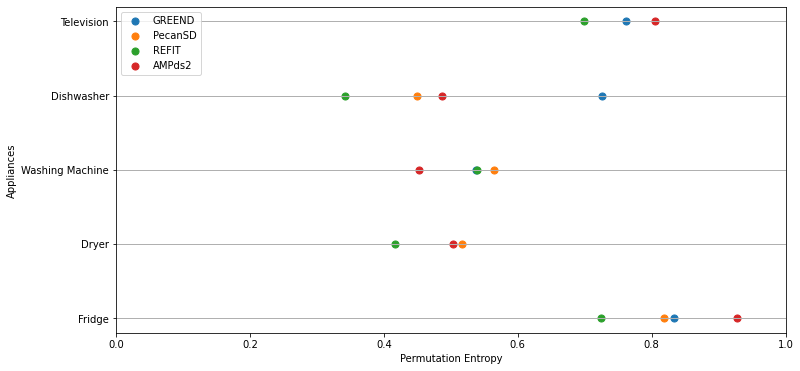

In [25]:
appl = ['Fridge', 'Dryer', 'Washing Machine', 'Dishwasher','Television']
#colors = cm.rainbow(np.linspace(0, 1, 4))
cmap = cm.get_cmap('tab20')

# Draw horizontal lines
marker_offset = 1
for df_, c, df_label in zip([df_gr, df_pc, df_rf, df_am], [cmap(0),cmap(0.1),cmap(0.2),cmap(0.3)], ['GREEND', 'PecanSD', 'REFIT', 'AMPds2']): 
  for i in range(len(appl)):
    if appl[i] in df_.columns.to_list():
      if i==0:
        plt.scatter(x = ent.weighted_permutation_entropy(df_[appl[i]].values, order = 7, delay=1, normalize=True), y = i+1,  color=c, s=50, label=df_label) 
        print(ent.weighted_permutation_entropy(df_[appl[i]].values, order = 7, delay=1, normalize=True))
      else:
        plt.scatter(x = ent.weighted_permutation_entropy(df_[appl[i]].values, order = 7, delay=1, normalize=True), y = i+1,  color=c, s=50)


plt.xlabel('Permutation Entropy')
plt.xlim(0,1)
plt.legend(loc='upper left')

plt.ylabel('Appliances')
plt.grid(axis='y',linestyle='-', linewidth=1) 
plt.yticks(np.arange(len(appl))+1, appl)

plt.show()